In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [6]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [7]:
result = llm.invoke("Hi how are you?")
result.content

"I'm just a language model, I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?"

In [8]:
urls = ["https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
        "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
        ]

docs = [WebBaseLoader(url).load() for url in urls]

In [9]:
docs[1][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
 'title': "Prompt Engineering | Lil'Log",
 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.',
 'language': 'en'}

In [10]:
docs[1][0].metadata['description']

'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.'

In [11]:
docs_list = [item for sublist in docs for item in sublist]

In [12]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [13]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=25
)

In [14]:
doc_splits = text_splitter.split_documents(docs_list)

In [15]:
len(doc_splits)

511

In [16]:
doc_splits[0].page_content

"LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

In [17]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings
)

In [18]:
retriever = vectorstore.as_retriever()

In [19]:
retriever_tool = create_retriever_tool(retriever,
                      "retrieve_blog_posts",
                      "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.")

In [20]:
tools = [retriever_tool]

In [21]:
retrieve = ToolNode(tools)

In [22]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def ai_assistant(state: AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        question = messages[-1].content
        prompt = PromptTemplate(
            template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
            Here is the question:{question}
            """,
            input_variables=["question"]
        )
        chain = prompt | llm
        
        response = chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tools = llm.bind_tools(tools)
        response = llm_with_tools.invoke(messages)
        return {"messages": [response]}

In [24]:
class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

In [25]:
def grade_document(state:AgentState) -> Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op = llm.with_structured_output(grade)
    
    prompt = PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user's question.
        Here is the document: {context}
        Here is the user's question: {question}
        If the document talks about or contains information related to the user's question, mark it as relevant.
        Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm_with_structure_op
    
    messages = state['messages']
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" # Node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" # Node name

In [26]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm
    
    response = rag_chain.invoke({"context": docs, "question":  question})
    print(f"this is my response: {response}")
    
    return {"messages": [response]}

In [27]:
from langchain_core.messages import HumanMessage

def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning.
                            Here is the initial question: {question}
                            Formulate an improved question: """)]
    
    response = llm.invoke(message)
    
    return {"messages": [response]}

In [28]:
workflow = StateGraph(AgentState)
workflow.add_node("My_AI_Assistant", ai_assistant)
workflow.add_node("Vector_Retriever", retrieve)
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite)
workflow.add_edge(START, "My_AI_Assistant")
workflow.add_conditional_edges("My_AI_Assistant", tools_condition, {"tools": "Vector_Retriever", END:END})
workflow.add_conditional_edges("Vector_Retriever", grade_document, {"generator": "Output_Generator", "rewriter": "Query_Rewriter"})
workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter","My_AI_Assistant")
app = workflow.compile()

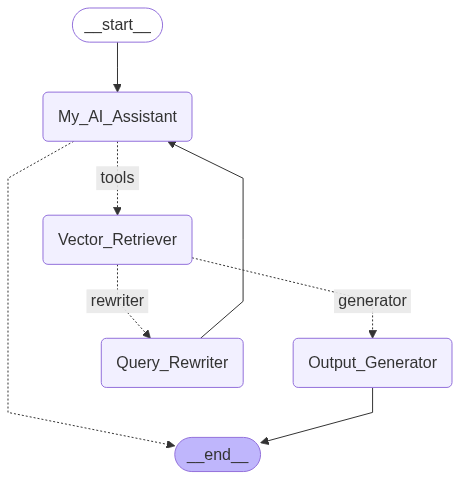

In [29]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
app.invoke({"messages":["What is an Autonomous Agent?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='What is an Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='89c8a704-01d2-4d47-be9d-18a28333f8c9'),
  AIMessage(content='An Autonomous Agent is a software system that perceives its environment and takes actions to achieve its goals, without direct human intervention. It can operate independently and make decisions based on its programming, data, and sensors. Autonomous Agents are designed to interact with humans, other agents, or the environment to accomplish specific tasks, such as decision-making, problem-solving, or control.\n\nAutonomous Agents can be applied in various domains, including artificial intelligence, robotics, gaming, and finance. They are often used in situations where human intervention is not feasible or desirable, such as in remote or hazardous environments.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 118, 'prompt_tokens': 1974, 'total_tokens': 2092, 'completion_time': 0.0983

In [33]:
result = app.invoke({"messages":["What is an Autonomous Agent?"]})

---CALL AGENT---


In [34]:
result['messages']

[HumanMessage(content='What is an Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='fc25b91a-7e60-48c5-afbe-44f263b4a396'),
 AIMessage(content='An Autonomous Agent is a software system that can perform tasks independently, without being controlled by human intervention. It can perceive its environment, reason about the information it receives, and make decisions and take actions based on that information. Autonomous agents can be used in various applications, such as robotics, artificial intelligence, and decision support systems.\n\nIn the context of artificial intelligence, autonomous agents are designed to act independently, making decisions and taking actions based on their own goals and objectives, without the need for human intervention. This can include tasks such as:\n\n* Perceiving the environment through sensors and data streams\n* Reasoning about the information received from the environment\n* Making decisions based on the information and goals\n* Taking a

In [35]:
result = app.invoke({"messages":["What is prompt engineering explain me in terms of agents and langchain?"]})
result['messages']

---CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---
this is my response: content="Prompt Engineering is the process of communicating with Large Language Models (LLMs) to achieve desired outcomes without updating the model weights. It involves crafting specific prompts to steer the agent's behavior, which can vary among models, requiring experimentation and heuristics to find effective approaches. In the context of LangChain, Prompt Engineering is a way to interact with the LLM agent to elicit specific responses." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 256, 'total_tokens': 336, 'completion_time': 0.066666667, 'prompt_time': 0.032382732, 'queue_time': 0.265974327, 'total_time': 0.099049399}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None} id='run--c17fe2b0-1b7b-4d6c-8a43-8ef6b8a263e4-0' usage_metadata={'input_tokens': 256, 'output_tokens': 80, 'total_toke

[HumanMessage(content='What is prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='a6a764d2-7580-4ab5-8765-e8cc7b31da9a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d2ea', 'function': {'arguments': '{"query":"What is prompt engineering?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 454, 'prompt_tokens': 985, 'total_tokens': 1439, 'completion_time': 0.378333333, 'prompt_time': 0.185360856, 'queue_time': 0.27019126299999996, 'total_time': 0.563694189}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7f715e63-e8b0-4bc8-9301-35b6f542ece9-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What is prompt engineering?'}, 'id': 'call_d2ea', 'type': 'tool_call'}], usage_metadata={'input_tokens': 985, 'output_tokens': 454, 'total_tokens': 1439

In [36]:
result['messages'][1].tool_calls

[{'name': 'retrieve_blog_posts',
  'args': {'query': 'What is prompt engineering?'},
  'id': 'call_d2ea',
  'type': 'tool_call'}]

In [37]:
result['messages'][-1].content

"Prompt Engineering is the process of communicating with Large Language Models (LLMs) to achieve desired outcomes without updating the model weights. It involves crafting specific prompts to steer the agent's behavior, which can vary among models, requiring experimentation and heuristics to find effective approaches. In the context of LangChain, Prompt Engineering is a way to interact with the LLM agent to elicit specific responses."

In [39]:
result = app.invoke({"messages":["Tell me about Taj Mahal"]})
result['messages']

---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


[HumanMessage(content='Tell me about Taj Mahal', additional_kwargs={}, response_metadata={}, id='af468ce5-7634-4ac5-a617-266851ef690b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w5kd', 'function': {'arguments': '{"query":"Taj Mahal"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 977, 'total_tokens': 1047, 'completion_time': 0.058333333, 'prompt_time': 0.212528922, 'queue_time': 0.395216756, 'total_time': 0.270862255}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--81a2c90e-5da1-4242-a939-d0ea85f306ae-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Taj Mahal'}, 'id': 'call_w5kd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 977, 'output_tokens': 70, 'total_tokens': 1047}),
 ToolMessage(content='The above step 1-3 are repeated for a number of iterations.\n\nare r

In [50]:
from pprint import pprint

input = {"messages":["What is an Autonomous Agent?"]}

for output in app.stream(input):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("/n--/n")
pprint(value['messages'][-1].content)

---CALL AGENT---
"Node 'My_AI_Assistant':"
'/n--/n'
('An autonomous agent is a system that can operate independently, making '
 'decisions and taking actions without direct human intervention. It can '
 'perceive its environment, reason about it, and make choices based on its own '
 'goals and objectives. Autonomous agents can be found in various forms, such '
 'as robots, software programs, and artificial intelligence systems.\n'
 '\n'
 'Autonomous agents can be characterized by their ability to:\n'
 '\n'
 '1. Perceive their environment: They can sense and gather information about '
 'their surroundings, such as sensors, cameras, or other data sources.\n'
 '2. Reason and learn: They can process the information they gather, learn '
 'from it, and adapt to new situations.\n'
 '3. Decide and act: They can make decisions and take actions based on their '
 'goals, policies, and the information they have gathered.\n'
 '4. Interact with humans: They can communicate with humans, receive '
 'i

In [55]:
input = {"messages":["What is prompt engineering explain me in terms of agents and langchain?"]}

for output in app.stream(input):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("-----------------------------------------")
    pprint(value['messages'][-1].content)

---CALL AGENT---
"Node 'My_AI_Assistant':"
'-----------------------------------------'
''
---DECISION: DOCS RELEVANT---
"Node 'Vector_Retriever':"
'-----------------------------------------'
('Prompt Engineering, also known as In-Context Prompting, refers to methods '
 'for how to communicate with LLM to steer its behavior for desired outcomes '
 'without updating the model weights. It is an empirical science and the '
 'effect of prompt engineering methods can vary a lot among models, thus '
 'requiring heavy experimentation and heuristics.\n'
 '\n'
 'OpenAI Cookbook has many in-depth examples for how to utilize LLM '
 'efficiently.\n'
 'LangChain, a library for combining language models with other components to '
 'build applications.\n'
 'Prompt Engineering Guide repo contains a pretty comprehensive collection of '
 'education materials on prompt engineering.\n'
 'learnprompting.org\n'
 'PromptPerfect\n'
 'Semantic Kernel\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I would consi